In [1]:
import sys
sys.path.append('../src')
from logger import log, debug
from cleaner import clean_corpus_basic
from reader import read_files
from nb_utils import get_best_tokens_dummy

from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt

import nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lefunes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lefunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
# -------------- Hiperparametros -----------------

min_each_q = 60
max_each_q = 70
interval = 1
min_lenght, max_length = 4, 8
train_to_test = 0.8

In [59]:
# Leemos los archivos
corpus = clean_corpus_basic(read_files("../dataset/", ["negative", "positive"]))

# Filtramos por longitud
debug("[El corpus tiene " + str(len(corpus)) + " rows]")

corpus["length"] = corpus["content"].map(lambda x: len(x.split(" ")))
corpus = corpus[(corpus["length"] >= min_lenght) & (corpus["length"] <= max_length)]

debug("[Luego de filtrar el corpus tiene " + str(len(corpus)) + " rows]")

#Shuffleamos el corpus
corpus = shuffle(corpus)
corpus.reset_index(inplace=True, drop=True)


[Leyendo archivos en panda...]
[Archivos Leidos...]
[Usando cleaner basico]
[Limpiando el corpus...]
[Usando 8 threads ...]
[El corpus tiene 20000 rows]
[Luego de filtrar el corpus tiene 9164 rows]


In [60]:

def to_nb_dictionaty(cleaned_sentence, best_tokens):
    to_ret = {}
    for item in best_tokens.iteritems():
        to_ret[item[0]] = 0
    tokens = nltk.word_tokenize(cleaned_sentence, 'spanish')
    for token in tokens:
        if (token in to_ret):
            to_ret[token] += 1
    return to_ret
    


In [61]:
def supertrain(train_set):
    train_set_splitted = np.array_split(train_set, 5)
    max_classifier = (None, 0)

    # la idea es hacer un cross-check, con 5 arrays
    splitted_len = len(train_set_splitted)
    for i in range(splitted_len):
        no_better_count = 0
        for _ in range(100): #Hacemos 100 iteraciones
            if(no_better_count > 10): #Despues de 10 iteraciones sin encontrar mejor, paramos
                break
                
            train_subset = train_set_splitted[0:i] + train_set_splitted[(i + 1): splitted_len]
            train_subset = [item for sublist in train_subset for item in sublist]
            np.random.shuffle(train_subset)

            np.random.shuffle(train_set_splitted[i])
                
            # Creamos el clasificador y lo evaluamos
            classifier = nltk.NaiveBayesClassifier.train(train_subset)
            acc = nltk.classify.accuracy(classifier, train_set_splitted[i])

            # Vemos si encontramos un clasificador mejor
            if(acc > max_classifier[1]):
                log("[   Se encontro un clasificador mejor " + str(acc * 100) + "% ]")
                max_classifier = (classifier, acc) # Guardamos el mejor clasificador
            no_better_count += 1 # Si no encontramos mejor, aumentamos en uno

    return max_classifier


In [68]:
results_nb = []

for p in range(min_each_q, max_each_q + 1, interval):
    log("[Entrenando con parametro " + str(p) + "]")
    best_tokens = get_best_tokens_dummy(corpus, p)
    corpus["nb_dict"] = corpus["content"].map(lambda x: to_nb_dictionaty(x, best_tokens))

    # Dividimos el corpus

    subset = corpus[['nb_dict','rate']]
    featuresets = [tuple(x) for x in subset.values]
    train, test = np.split(featuresets, [int(train_to_test * len(featuresets))])
    clasif = supertrain(train)

    real_acc = nltk.classify.accuracy(clasif[0], test)
    
    log("[   Accuaracy real " + str(real_acc * 100) + "% ]")
    
    results_nb.append((p, real_acc, clasif[0], clasif[1]))
log("[Fin del entrenamiento]")


[Entrenando con parametro 60]
[   Se encontro un clasificador mejor 92.77436946148603% ]
[   Se encontro un clasificador mejor 93.38335607094133% ]
[   Accuaracy real 92.74413529732679% ]
[Entrenando con parametro 61]
[   Se encontro un clasificador mejor 92.77436946148603% ]
[   Se encontro un clasificador mejor 93.45156889495226% ]
[   Accuaracy real 92.68957992362247% ]
[Entrenando con parametro 62]
[   Se encontro un clasificador mejor 92.91070211315609% ]
[   Se encontro un clasificador mejor 93.65620736698499% ]
[   Accuaracy real 92.74413529732679% ]
[Entrenando con parametro 63]
[   Se encontro un clasificador mejor 92.91070211315609% ]
[   Se encontro un clasificador mejor 93.65620736698499% ]
[   Accuaracy real 92.74413529732679% ]
[Entrenando con parametro 64]
[   Se encontro un clasificador mejor 92.91070211315609% ]
[   Se encontro un clasificador mejor 93.65620736698499% ]
[   Accuaracy real 92.8532460447354% ]
[Entrenando con parametro 65]
[   Se encontro un clasificador

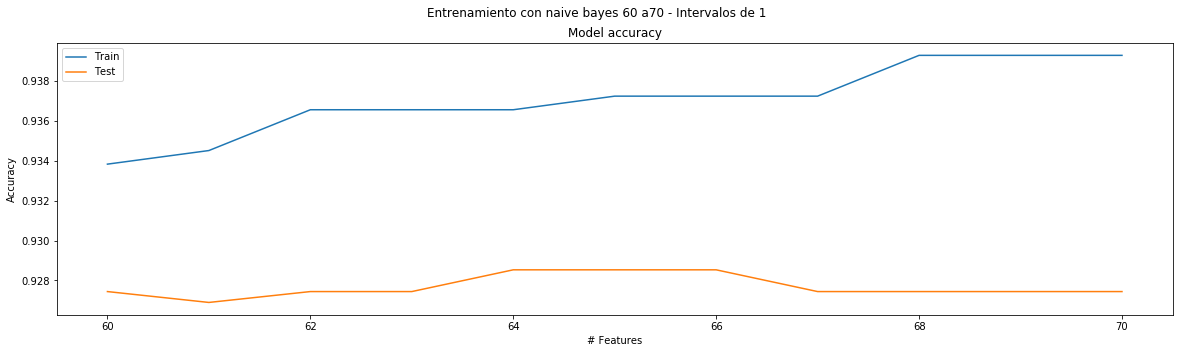

In [69]:
graph_prefix = "restricted_nb_60_70"

param_list = []
real_acc_list = []
acc_list = []
for (param, real_acc, clasif, acc) in results_nb:
    param_list.append(param)
    real_acc_list.append(real_acc)
    acc_list.append(acc)
    
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Entrenamiento con naive bayes ' + str(min_each_q) +' a'  + str(max_each_q)+  ' - Intervalos de ' + str(interval))

plot = fig.add_subplot(1, 1, 1)

# Plot training & validation accuracy values
plot.plot(param_list, acc_list, label= "Train")
plot.plot(param_list, real_acc_list, label= "Test")

plot.set_title('Model accuracy')
plot.set_ylabel('Accuracy')
plot.set_xlabel('# Features')
plot.legend(loc="upper left")


fig.savefig('./graphs/' + graph_prefix + '.png')